In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras import backend as K
from tensorflow import keras

import numpy as np
import os

from matplotlib import pyplot as plt

from vis.visualization import visualize_activation
from vis.utils import utils

In [6]:
model = keras.models.load_model("models/new_arch/chb02_threshold_0.887_false_neg_0_true_neg_3115_false_pos_364_true_pos_39_accuracy_90_regularised.h5")
ictal_data = np.load("ml_processed_balanced/chb02_16+.edf_data.npy")
ictal_labels = np.load("ml_processed_balanced/chb02_16+.edf_labels.npy")

ictal_true = ictal_data[120]
print(ictal_true.shape)
ictal_false = ictal_data[30]

(23, 256)


In [4]:
filters, bias = model.layers[0].get_weights()
avgs = []
for kernel in filters:
    avgs.append(np.mean(kernel, axis=1))
avgs = np.asarray(avgs)
print(avgs.shape)
avg = avgs[0]
print(min(avg), max(avg))
avg_min, avg_max = np.min(avg), np.max(avg)
avg_normalised = (avg - avg_min)/(avg_max - avg_min)
print(min(avg_normalised), max(avg_normalised))
print(avg_normalised)



(5, 256)
-0.013956022 0.019807842
0.0 1.0
[0.4788011  0.4669051  0.48373526 0.5241056  0.20237991 0.29466465
 0.38023028 0.39999992 0.1558315  0.11596285 0.22932543 0.26495373
 0.13416108 0.3746293  0.5977981  0.597603   0.3489102  0.3737004
 0.2989927  0.23791863 0.52027416 0.34242192 0.31558475 0.6488667
 0.5121568  0.14498053 0.46747133 0.54653066 0.4105496  0.27141824
 0.35893434 0.33542013 0.3236499  0.5395471  0.6143778  0.7312784
 0.60950845 0.57302517 0.27627265 0.13834126 0.5621196  0.5953695
 0.21544266 0.3694562  0.63808256 0.2261213  0.24751678 0.39084485
 0.20170201 0.3348446  0.361631   0.45385405 0.44569448 0.730603
 0.6731794  0.45535782 0.22996026 0.39092547 0.4995348  0.21786197
 0.31499982 0.71300447 0.35974818 0.28462064 0.37873712 0.42708644
 0.49345464 0.5033047  0.43249002 0.33680433 0.47051167 0.59523
 0.50628805 0.45116848 0.5396196  0.4912617  0.2929313  0.37178063
 0.6006485  0.4171999  0.14325343 0.37894687 0.30274835 0.18662943
 0.21161456 0.16114935 0.0683

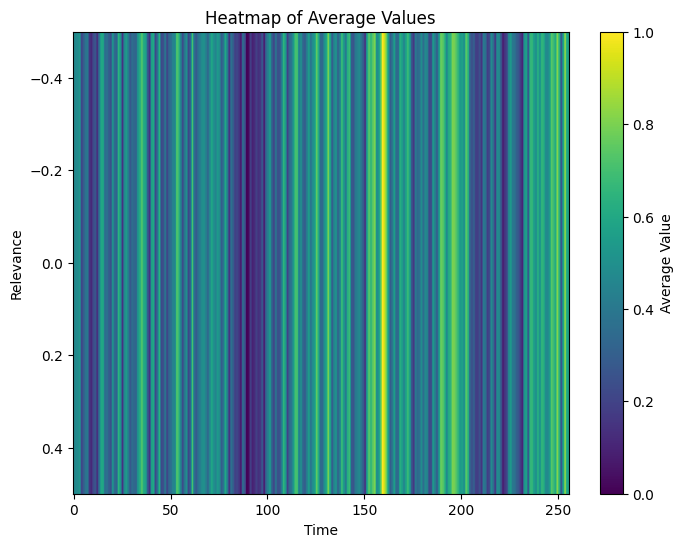

In [30]:
plt.figure(figsize=(8, 6))
plt.imshow(avg_normalised.reshape(1, -1), cmap='viridis', aspect='auto')
plt.colorbar(label='Average Value')
plt.title('Heatmap of Average Values')
plt.xlabel('Time')
plt.ylabel('Relevance')
plt.show()

In [16]:
# Function to extract activations from intermediate layers
get_activations = K.function([model.layers[0].input], [model.layers[i].output for i in range(len(model.layers))])

# Get activations for the first convolutional layer
layer_outputs = get_activations([np.expand_dims(ictal_true, axis=0)])[0]  # Assuming first conv layer is index 1

(1, 19, 512)


<Figure size 640x480 with 0 Axes>

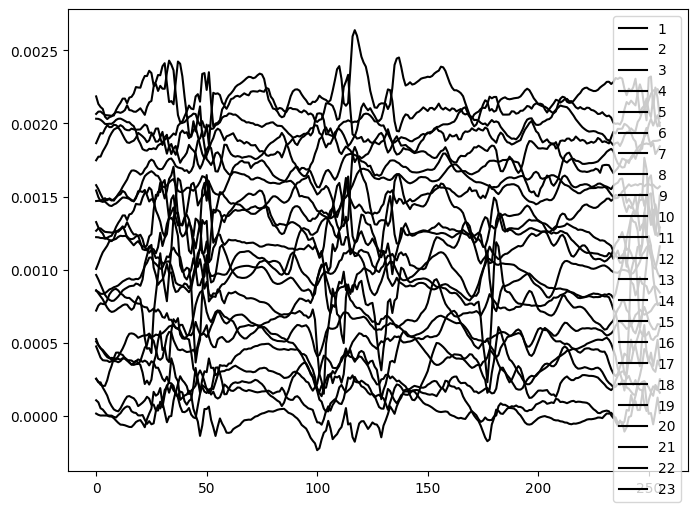

In [17]:
print(layer_outputs.shape)

plt.clf()
plt.figure(figsize=(8,6))
for i, sensor in enumerate(ictal_true):
    plt.plot(sensor + i*0.0001, label=i+1, color="black")
plt.legend()
plt.show()

In [23]:
def normalize_activations(activations):
    activations -= np.min(activations)
    activations /= np.max(activations)
    return activations

# Function to overlay activations on EEG data
def overlay_activations(eeg_data, activations):
    num_sensors = eeg_data.shape[0]
    num_samples = eeg_data.shape[1]
    num_filters = activations.shape[-1]
    
    # Normalize activations
    normalized_activations = normalize_activations(activations)
    
    # Plot EEG data
    plt.figure(figsize=(8, 6))
    for i in range(num_sensors):
        plt.plot(eeg_data[i] + i * 0.0001, color="black", alpha=0.5, label=f"Sensor {i + 1}")

    # Plot normalized activations
    if num_filters == 1:
        color = plt.cm.jet(normalized_activations.squeeze())
        for i in range(num_sensors):
            plt.plot(normalized_activations.squeeze() * eeg_data[i].max() * 0.5 + i * 0.0001, 
                     color=np.array([color]),  # Convert color to array
                     alpha=0.5, label="Filter 1")
    else:
        for f in range(num_filters):
            for i in range(num_sensors):
                color = plt.cm.jet(normalized_activations[0, :, f])
                plt.plot(normalized_activations[0, :, f] * eeg_data[i].max() * 0.5 + i * 0.0001, 
                         color="red",  # Convert color to array
                         alpha=0.5, label=f"Filter {f + 1}")

    plt.legend()
    plt.show()

# Assuming ictal_true is your EEG data
# Get activations for the first convolutional layer
layer_outputs = get_activations([np.expand_dims(ictal_true, axis=0)])[0]

# Overlay activations on EEG data
overlay_activations(ictal_true, layer_outputs)

c:\Users\angus\Documents\cs408-eeg-python\venv3.7\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 697x247154 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>